1) Using stock ticker being able to pull the available tickers for the corresponding FnO.
2) Being able to get dynamic symbols for the past 30 days to backtest strategies. First for a single stock and then for multiple stocks.

1) For expiry analysis, I should be able to figure out the end of day price range or the movement of price of the underlying using the trade data such as options, volumes of futures traded, option chain and corresponding changes in the option chain data 

In [2]:
import h5py
import numpy as np
from datetime import datetime
from pathlib import Path

def load_training_data(symbol: str, data_dir: str = None):
    if data_dir is None:
        # Go one folder back from ML learning to training_data
        data_dir = Path.cwd().parent/ "training_data"
    else:
        data_dir = Path(data_dir)
    
    filepath = data_dir / f"{symbol}_training.h5"
    
    if not filepath.exists():
        raise FileNotFoundError(f"File not found: {filepath}")
    with h5py.File(filepath, 'r') as f:
        data = {
            'features': f['features'][:],      # (n_snapshots, 11, strikes)
            'greeks': f['greeks'][:],          # (n_snapshots, 10, strikes)
            'timestamps': f['timestamps'][:]   # (n_snapshots,)
        } 
    return data

In [3]:
symbol = "HDFCBANK"
data = load_training_data(symbol, None)

In [4]:
data['features']
data['greeks']
data['timestamps']

array([1.76369779e+09, 1.76369780e+09, 1.76369781e+09, ...,
       1.76406481e+09, 1.76406482e+09, 1.76406483e+09])

In [5]:
import pandas as pd

ts = pd.to_datetime(data['timestamps'], unit='s', utc=True).tz_convert('Asia/Kolkata')
print(ts)

DatetimeIndex(['2025-11-21 09:33:11.692487717+05:30',
               '2025-11-21 09:33:20.004919767+05:30',
               '2025-11-21 09:33:26.576789618+05:30',
               '2025-11-21 09:33:33.472461462+05:30',
               '2025-11-21 09:33:41.840873241+05:30',
               '2025-11-21 09:33:50.943651438+05:30',
               '2025-11-21 09:33:56.935845852+05:30',
               '2025-11-21 09:34:02.739259720+05:30',
               '2025-11-21 09:34:07.610556364+05:30',
               '2025-11-21 09:34:13.626413584+05:30',
               ...
               '2025-11-25 15:29:30.869181871+05:30',
               '2025-11-25 15:29:36.389045954+05:30',
               '2025-11-25 15:29:41.664039612+05:30',
               '2025-11-25 15:29:47.211928368+05:30',
               '2025-11-25 15:29:53.525655270+05:30',
               '2025-11-25 15:29:58.590602636+05:30',
               '2025-11-25 15:30:05.190634489+05:30',
               '2025-11-25 15:30:11.103260517+05:30',
         

In [6]:
data['greeks'][:1]

array([[[ 0.16355563,  0.15363855,  0.15087455,  0.16093397,
          0.16855052,  0.17272193,  0.17892344],
        [ 0.14883912,  0.14362436,  0.14256484,  0.1509264 ,
          0.15716532,  0.16089628,  0.16512431],
        [ 0.82514415,  0.75213192,  0.64655533,  0.5229302 ,
          0.41076677,  0.31107402,  0.2304267 ],
        [-0.15244697, -0.23342111, -0.34566162, -0.47598221,
         -0.59605491, -0.70205236, -0.78831082],
        [ 0.01497341,  0.01957105,  0.02341858,  0.02352427,
          0.02193324,  0.01944456,  0.01614825],
        [ 0.01505156,  0.02026224,  0.024583  ,  0.02508008,
          0.02342541,  0.02047705,  0.01666853],
        [-0.73206176, -0.80188557, -0.87779136, -0.95651267,
         -0.95138025, -0.87025519, -0.76540418],
        [-0.42744575, -0.52637323, -0.61433157, -0.68422075,
         -0.66727053, -0.57603641, -0.45156888],
        [ 0.27104548,  0.33279009,  0.3910503 ,  0.41900568,
          0.40915602,  0.37170782,  0.31977817],
        [ 

In [7]:
import matplotlib.pyplot as plt

import numpy as np

T, G, S = data['greeks'].shape
print(T , G,  S)

11173 10 7


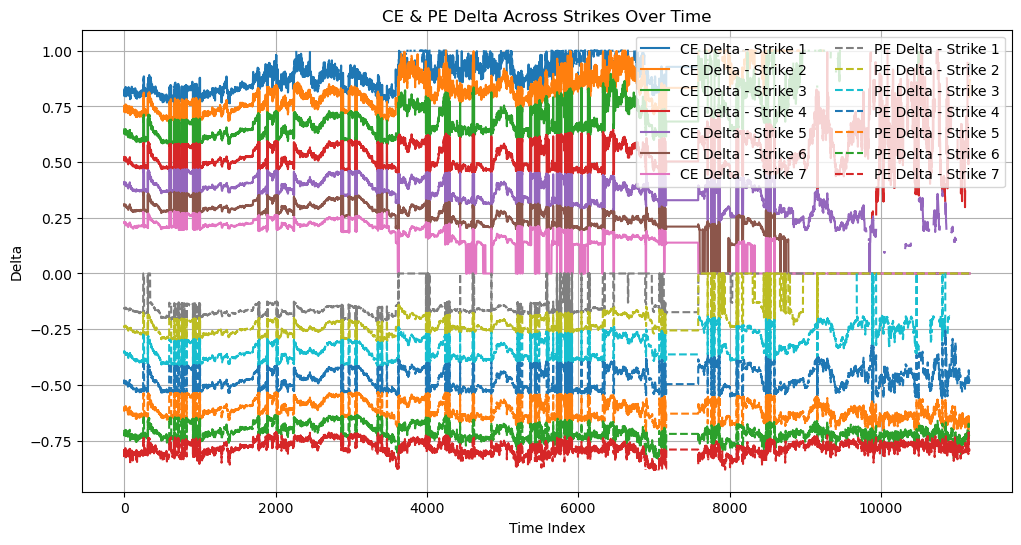

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# arr = your 3D array (T, 10, S)

T, G, S = greeks.shape
time_axis = np.arange(T)

CE_DELTA = greeks[:, 2, :]   # shape = (T, S)
PE_DELTA = greeks[:, 3, :]   # shape = (T, S)

plt.figure(figsize=(12, 6))

# Plot CE delta for all strikes
for i in range(S):
    plt.plot(time_axis, CE_DELTA[:, i], label=f"CE Delta - Strike {i+1}")

# Plot PE delta for all strikes
for i in range(S):
    plt.plot(time_axis, PE_DELTA[:, i], linestyle='--', label=f"PE Delta - Strike {i+1}")

plt.title("CE & PE Delta Across Strikes Over Time")
plt.xlabel("Time Index")
plt.ylabel("Delta")
plt.legend(ncol=2)
plt.grid(True)
plt.show()

In [28]:
Step 1: Data Collection & Engineering
    Minute-by-Minute Data Sources:
    Underlying prices (1-minute OHLCV)
    Options data (CE/PE prices, volumes, OI for multiple strikes)
    Futures data (prices, volumes, OI)
    Option chain changes (OI changes, volume spikes)
    Greeks (Delta, Gamma, Theta, Vega if available)
    Implied Volatility (IV changes)
    
    Feature Engineering:
    Volume ratios (options volume vs underlying volume)
    Put-Call ratios (by volume and OI)
    OI changes (delta OI for different strikes)
    Price momentum (rolling averages, RSI, MACD)
    Volatility measures (realized vs implied)
    Gamma exposure (estimated from OI)
    Time decay effects (theta exposure)

Step 2: Target Variable Creation
    Movement Classification:
    Direction: Up/Down/Neutral (with thresholds)
    Magnitude: Small (<0.3%), Medium (0.3-1%), Large (>1%)
    Time horizon: Next 5min, 15min, 30min, 1hr
    Confidence Scoring:
    Probability distribution over price ranges
    Expected move with confidence intervals

Step 3: Model Architecture Options
    Traditional ML:
    Random Forest (for feature importance)
    XGBoost/LightGBM (for non-linear patterns)
    SVM (for classification)
    Deep Learning:
    LSTM/GRU (for time series patterns)
    Transformer (for attention mechanisms)
    CNN-LSTM (for spatial-temporal patterns)
    Ensemble models (combining multiple approaches)

Step 4: Data Pipeline
    Real-time Processing:
    Streaming data ingestion
    Feature calculation on-the-fly
    Model inference every minute
    Confidence scoring and alerts
    Backtesting Framework:
    Walk-forward analysis
    Out-of-sample testing
    Performance metrics (accuracy, Sharpe ratio, max drawdown)

Step 5: Model Training Strategy
    Data Split:
    Training: 60% (historical data)
    Validation: 20% (for hyperparameter tuning)
    Testing: 20% (final evaluation)
    Cross-validation:
    Time series CV (no data leakage)
    Rolling window validation

Step 6: Performance Metrics
    Prediction Accuracy:
    Direction accuracy (up/down prediction)
    Magnitude accuracy (range prediction)
    Confidence calibration (reliability of confidence scores)
    Trading Metrics:
    Hit rate (profitable predictions)
    Risk-adjusted returns
    Maximum drawdown

Step 7: Implementation Phases
    Phase 1: Data Collection
    Set up minute-by-minute data feeds
    Build feature engineering pipeline
    Create target variables
    
    Phase 2: Model Development
    Start with simple models (Random Forest)
    Add complexity (LSTM, Transformer)
    Implement ensemble methods
    
    Phase 3: Backtesting
    Historical performance analysis
    Risk management rules
    Position sizing strategies
    
    Phase 4: Live Trading
    Real-time model deployment
    Monitoring and alerting
    Continuous model updates

Step 8: Key Considerations
    Market Regimes:
    Bull/Bear markets (different patterns)
    High/Low volatility periods
    Expiry effects (gamma squeeze, pinning)
    Risk Management:
    Position limits based on confidence
    Stop losses and take profits
    Portfolio diversification
    Model Maintenance:
    Regular retraining (weekly/monthly)
    Feature drift monitoring
    Performance degradation alerts
    This approach will give you a sophisticated system that can predict price movements with confidence intervals, perfect for options trading strategies!

SyntaxError: invalid decimal literal (401078594.py, line 23)

Additional tricks used by quant teams

Regime classification first, prediction second (e.g., volatility regime via HMM or k-means)

Rolling retraining (every few days/hours) to handle drift

Ensemble averaging of models trained on different lookbacks

Online learning or partial retraining (LightGBM supports this nicely)

Each underlying and its futures and options lands in its own in-memory buffers and/or durable store without mixing symbols.


Using Normalized routing key:  (underlying, expiry) ----------> (underlying) is preferred
-Of this underlying, the inside structure for can could be Reliance: {stock:987, Stock_FUT:988, CE

